# Assignment 3

**Assignment 3: Evolutionary Algorithms**

**Goal**: Get familiar with evolutionary algorithms by implementing it and applying it to a given non-differentiable optimization task.

In this assignment, we are going to learn about evolutionary algorithms (EAs). The goal is to implement components of an evolutionary algorithm: a recombination operator, a mutation operator, and selection mechanisms, and analyze their behavior. This assignment is open to any choice of the aforementioned components​ as long as they are well motivated.

We are interested in optimizing a given **black-box** function that could be queried (i.e., it returns a value of the objective for given input values), but the gradient wrt the input cannot be calculated. The input to the system is a vector:
$$\mathbf{x} =[\alpha_0, n, \beta, \alpha]^{\top} \in [−2,10] \times [0,10] \times [−5,20] \times [500,2500]. $$

The optimized function is based on the gene repressilator model. For details, please see Section 4.2 in <a href='https://arxiv.org/abs/2002.02869' target='_blank'>HERE</a>.

## 1. Understanding the problem

The considered problem is about finding parameter values of a model widely used in biology, namely, the gene repressilator model. This model represents a simple network in which a gene (mRNA) is produced by a protein, and then this gene is used to produce another protein. Altogether, there are 3 genes and 3 proteins that are connected as follows: $m_1 \rightarrow p_1$, $p_1 \rightarrow m_2$, $m_2 \rightarrow p_2$, $p_2 \rightarrow m_3$, $m_3 \rightarrow p_3$, $p_3 \rightarrow m_1$.

Please run the code below and spend a while on analyzing the signals in the model. Think of the osscilatory character of the signals.

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import copy
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

EPS = 1.0e-7

In [2]:
# PLEASE DO NOT REMOVE!
# This is the main class for the gene repressilator model.
# There is no need to understand how it works! You can treat it as a black-box.
# It is important to realize that we can always ask this object to give us
# an evaluation of given parameter values.
class Repressilator(object):
    def __init__(self, y_real, params):
        super().__init__()
        self.y_real = y_real.copy()
        self.params = params.copy()

    # The definition of the gene repressilator model as a system of ODEs.
    def repressilator_model(self, t, y):
        m1, m2, m3, p1, p2, p3 = y[0], y[1], y[2], y[3], y[4], y[5]

        alpha0 = self.params["alpha0"]
        n = self.params["n"]
        beta = self.params["beta"]
        alpha = self.params["alpha"]

        dm1_dt = -m1 + alpha / (1.0 + p3**n) + alpha0
        dp1_dt = -beta * (p1 - m1)
        dm2_dt = -m2 + alpha / (1.0 + p1**n) + alpha0
        dp2_dt = -beta * (p2 - m2)
        dm3_dt = -m3 + alpha / (1.0 + p2**n) + alpha0
        dp3_dt = -beta * (p3 - m3)

        return dm1_dt, dm2_dt, dm3_dt, dp1_dt, dp2_dt, dp3_dt

    # A numerial solver for the model (here we use Runge-Kutta 4.5)
    def solve_repressilator(self):
        # we need to use lambda function if we want to pass some parameters
        solution = solve_ivp(
            lambda t, y: self.repressilator_model(t, y),
            t_span=(self.params["t0"], self.params["t1"]),
            y0=self.params["y0"],
            method="RK45",
            t_eval=self.params["t_points"],
        )
        y_points = np.asarray(solution.y)
        return self.params["t_points"], y_points

    # An auxiliary function: setting parameters.
    def set_params(self, x):
        self.params["alpha0"] = x[0]
        self.params["n"] = x[1]
        self.params["beta"] = x[2]
        self.params["alpha"] = x[3]

    # Calculating the objective function.
    # Here, we use the Euclidean distance between the real data and the synthetic data.
    @staticmethod
    def loss(y_real, y_model):
        # we assume only m's are observed!
        y_r = y_real[0:3]
        y_m = y_model[0:3]
        if y_r.shape[1] == y_m.shape[1]:
            return np.mean(np.sqrt(np.sum((y_r - y_m) ** 2, 0)))
        else:
            return np.infty

    def objective(self, x):
        if len(x.shape) > 1:
            objective_values = []
            for i in range(x.shape[0]):
                xi = x[i]
                self.set_params(xi)

                _, y_model = self.solve_repressilator()
                objective_values.append(self.loss(self.y_real, y_model))

            objective_values = np.asarray(objective_values)
        else:
            self.set_params(x)

            _, y_model = self.solve_repressilator()
            objective_values = self.loss(self.y_real, y_model)

        return objective_values

In [3]:
# PLEASE DO NOT REMOVE!
# Initialize the problem.
# Here we set the real parameters and generate "real" data. To make the problem
# more realistic, we add a small Gaussian noise.
params = {}
params["alpha0"] = 1.1
params["n"] = 2.9
params["beta"] = 5.5
params["alpha"] = 500
params["t0"] = 0.0
params["t1"] = 60.5
params["t_points"] = np.arange(0, 60, 0.5)
params["x0"] = np.asarray([[5.64167522, 2.07180539, 3.56690274, 7.0015145]])
params["y0"] = np.asarray([0.0, 0.0, 0.0, 2.0, 1.0, 3.0])

# Generate "real" data
r = Repressilator([0], params)
_, y_real = r.solve_repressilator()
del r  # we remove the object, just in case
y_real = y_real + np.random.randn(*y_real.shape) * 5.0  # add noise!

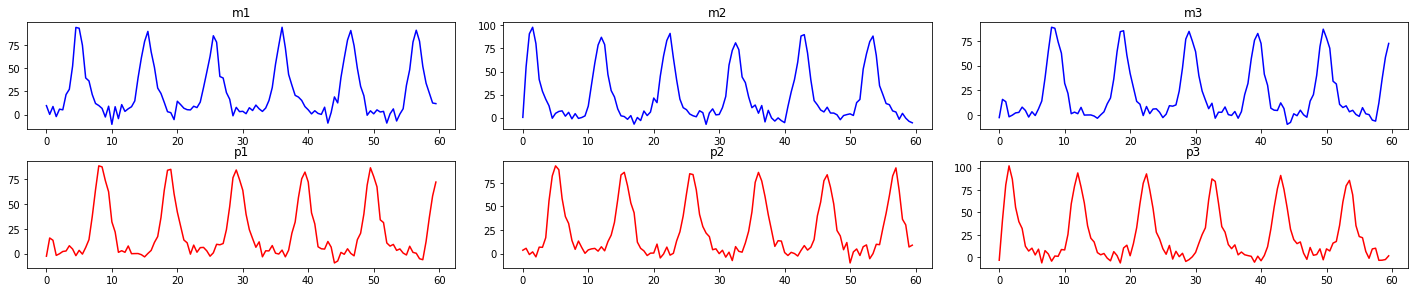

In [4]:
# PLEASE DO NOT REMOVE
# Here, we plot all signals in the model.
# Note that later on, we assume that only gene expression (i.e., m1, m2, m3)
# are observed (blue plots) and proteins (i.e. p1, p2, p3) are unobserved (in red).
t = params["t_points"]

fig_data, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_data.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
        else:
            title = "p"
            color = "r"

        axs[i, j].plot(t, y_real[2 * i + j], color)
        axs[i, j].set_title(title + str(j + 1))

## 2. Evolutionary Algorithms

In this assignment, you are asked to implement an evolutionary algorithm (EA). Please take a look at the class below and fill in the missing parts. Please keep in mind that you are free to choose any operations as lons as they are appropriate for evolutionary algorithms.

NOTE: Please pay attention to the inputs and outputs of each function.

**Question 1 (0-0.5pt):** Do you use a mutation operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
My aproach holisticly is to try everything, to familiarize myself with the concepts and the code.

I will thus use a mutation operator as it is quite common, especially as it serves as a way to add genetic material to the population. It helps make sure there is diversity and thus prevent premature convergence, but for big populations it serves . We can conclude from this that it also helps escape local minima and adds more exploration. It is also used in all of the evolutionary algorithms we talked about. It is important to note that I onl found random-noise to be suitable as we have a 4 bit float as our values and not all mutations work for all types of formats.

**Question 2 (0-0.5pt):** Do you use a cross-over operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
A cross-operator is a something that uses two parents to create an offspring solution, it is not always necessary to use, it depends on the specific function. It is however very common, used in majority of the EAs we talked about, only Evolution Strategies and Estimation of the distribution algorithm don't have it. In my implementation I will use it, as it is quite powerful to be able to create offspring and thus more values to compare andd choose the best ones from. In theory this should increase convergence.

**Question 3 (0-0.5pt):** What kind of selection mechanism do you use? Please explain in detail and motivation your choice.

**Answer:**
For parent selection, I chose tournament as is sounded fun to implement and the tournament size variable is easy to change and thus find the optimal value for. The tournament compares X (tournament size) number of parents together and chooses the best one of those, which will cull the population, leaving only the fittest individuals, all based on fitness.

For final selction, or survivor selection, I simply take the original population size best fitness ones, which become my survivors. It is important to keep the popuation size to keep the number of independent variables under my control and be able to judge the changes mostly on those.

**Question 4 (0-0.5pt):** Do you use any other operation? If yes, please explain and motivate your choice.

**Answer:**
I did not add anything extra as it was imprtant to keep the number of variables managable, and also to not potentially break the code. I already implemnted all the methods we discussed so I believed it to be more than sufficient.

**Question 5 (0-0.5-1pt):** Please provide a pseudo-code for your evolutionary algorithm. Please try to be as formal as possible!

**Answer:**
Create class EA (variables = repressilator, pop_size, tournament_size, crossover_rate, mutation_rate, bounds_min=None, bounds_max=None):
    set self.repressilator from repressilator
    set self.pop_size from pop_size
    set self.bounds_min from bounds_min
    set self.bounds_max from bounds_max
    set self.mutation_rate from mutation_rate
    set self.crossover_rate from crossover_rate
    set self.tournament_size from tournament_size

Function parent_selection(x_old, f_old):
    x_parents = empty array like x_old
    f_parents = empty array like f_old
    Forloop i in range(pop_size):
        index = random integer from 0 to pop_size with size tournament_size
        winner = index of minimum value in f_old with index from above step
        x_parents[i] = value of x_old with the index equal to the winner from above
        f_parents[i] = value of f_old with the index equal to the winner from above
    End forloop
    return x_parents, f_parents

Function recombination(x_parents, f_parents):
    x_children = empty list
    forloop i in range(pop_size):
        Check if random number between 0 and 1 is less than self.crossover_rate:
            parent1_idx = random integer from 0 to length of x_parents
            parent2_idx = random integer from 0 to length of x_parents
            whileloop parent1_idx same as parent2_idx:
                parent2_idx = random integer from 0 to length of x_parents
            End whileloop
            parent1 = x_parents[parent1_idx]
            parent2 = x_parents[parent2_idx]
            child = array of zeros like parent1
            crossover_point = random integer from 0 to length of child
            child[:crossover_point] = genes from parent1 up to the crossover_point
            child[crossover_point:] = genes from parent2 from crossover_point till the end
            add child to x_children
        else:
            add x_parents[i] to x_children
    End forloop
    return x_children

Function mutation(x_children):
    forloop i in range(length of x_children):
        forloop j in range(length of x_children[0]):
           check if random number between 0 and 1 is less than self.mutation_rate:
                noise = random number from a normal distribution with mean 0 and standard 
deviation 0.01
                add noise to x_children[i][j]
               check if self.bounds_min is not None:
                    x_children[i][j] = max(x_children[i][j], self.bounds_min[j])
                Check if self.bounds_max is not None:
                    x_children[i][j] = min(x_children[i][j], self.bounds_max[j])
        End forloop
    End forloop
    convert x_children to numpy array and return

Function survivor_selection(x_old, x_children, f_old, f_children):
    x = concatenate x_old and x_children
    f = concatenate f_old and f_children
    sort x and f in ascending order of f
    select fittest pop_size individuals from x and f and return

Function evaluate(x):
    return self.repressilator.objective(x)

Function step(x_old, f_old):
    x_parents, f_parents = call parent_selection(x_old, f_old)
    x_children = call recombination(x_parents, f_parents)
    x_children = call mutation(x_children)
    f_children = call evaluate(x_children)
    x, f = call survivor_selection(x_old, x_children, f_old, f_children)
    return x, f


In [103]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but some functions are incorrect and it is badly explained
# 1.0 pt if code works but some functions are incorrect
# 2.0 pt if code works but it does not correspond to the description above and it is badly explained
# 2.5 pt if code works and it is well explained, but it does not correspond to the description above
# 3.0 pt if code works and it is aligned with the description about, but it is badly explained
# 3.5 pt if code works and it is aligned with the description about, and it is well explained
# 4.0 pt if code works, it is as it was described, it is well explained, and the proposed operations are beyond the lecture!
# =========
# Implement the Evolutionary Algorithm (EA) algorithm.
# It is equivalent to implementing the step function.

#added inits for own vars
class EA(object):
    def __init__(self, repressilator, pop_size,  tournament_size, crossover_rate, mutation_rate, bounds_min=None, bounds_max=None):
        self.repressilator = repressilator
        self.pop_size = pop_size
        self.bounds_min = bounds_min
        self.bounds_max = bounds_max
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.tournament_size = tournament_size

    def parent_selection(self, x_old, f_old):
        # pick parents with the best values
        # tournament selection
        
        # create empty lists of the correct format        
        x_parents = np.zeros_like(x_old)
        f_parents = np.zeros_like(f_old)
        
        # loop over population size
        for i in range(self.pop_size):
            
            # pick indexes on scale of population size
            index = np.random.randint(0, self.pop_size, size=self.tournament_size)
            
            # winner is lower value f
            winner = np.argmin(f_old[index])
            
            # add winner to same spot in both lists
            x_parents[i] = x_old[index[winner]]
            f_parents[i] = f_old[index[winner]]
        
        return x_parents, f_parents

    def recombination(self, x_parents, f_parents):
        # take 2 parents and use them to make X amount of children
        # shuffle the genes
        
        # empty children list
        x_children = []
        
        # loop over population size
        for i in range(self.pop_size):
            
            # check significance of random number
            if np.random.rand() < self.crossover_rate:
                
                # random index per parent from parent list
                parent1_idx = np.random.randint(len(x_parents))
                parent2_idx = np.random.randint(len(x_parents))
                
                #make sure parents are diff
                while parent1_idx == parent2_idx:
                    parent2_idx = np.random.randint(len(x_parents))
                    
                # var names for parents
                parent1 = x_parents[parent1_idx]
                parent2 = x_parents[parent2_idx]
                
                # copy parent format
                child = np.zeros_like(parent1)
                
                # assign point from child length
                crossover_point = np.random.randint(len(child))
                
                # crossover the parents at the crossover point
                child[:crossover_point] = parent1[:crossover_point]
                child[crossover_point:] = parent2[crossover_point:]
                x_children.append(child)
                
            # in case the rand number is insignificant, just append parent
            else:
                x_children.append(x_parents[i])

        return x_children

    def mutation(self, x_children): # random-noise
        # floating point type mutation - genes are 4 floating point nums
        # takes genes and rondomly amkes vompletetely new vlaues, not from parents but random
        
        for i in range(len(x_children)):
            for j in range(len(x_children[0])):
                
                #check significance against mutation rate
                if np.random.uniform(0, 1) < self.mutation_rate:
                    
                    # Generate random noise
                    noise = np.random.normal(0, 0.01)
                    
                    # Add noise to the current child
                    x_children[i][j] += noise
                    
                    # use bounds if necessary
                    if self.bounds_min is not None:
                        x_children[i][j] = max(x_children[i][j], self.bounds_min[j])
                    if self.bounds_max is not None:
                        x_children[i][j] = min(x_children[i][j], self.bounds_max[j])
                        
        # change to array so .shape works                
        x_children = np.array(x_children)
        
        return x_children

    def survivor_selection(self, x_old, x_children, f_old, f_children):
        # which of the children/population actually get tot survive (removing ones with worse fitness value)
        # who gets to live
        
        # change so we can use further functions
        x = np.concatenate([x_old, x_children])
        f = np.concatenate([f_old, f_children])

        # sort by fitness in ascending order, keep aligned 
        sorted_idx = np.argsort(f)
        x = x[sorted_idx]
        f = f[sorted_idx]
        
        # Select the fittest individuals as the new population, cut off at old population size
        x = x[:self.pop_size]
        f = f[:self.pop_size]
        
        return x, f

    # Evaluation step: DO NOT REMOVE!
    def evaluate(self, x):
        return self.repressilator.objective(x)

    def step(self, x_old, f_old):   
        #x_parents is a big list of the population, list of lists
        #f_parents ocntians the fitness of the parents of x_parents !in the same order!
        
        x_parents, f_parents = self.parent_selection(x_old, f_old)

        x_children = self.recombination(x_parents, f_parents)
        
        x_children = self.mutation(x_children)
    
        f_children = self.evaluate(x_children)

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

        return x, f

### **NOTE 1**

Since this assignment allows you implementing your own operations, this is difficult to prepare a code for that. Therefore, please use the code below to find the best set of your hyperparameters in a separate file, and then present your analysis for the best values of the hyperparameters here.

I made a testing code which tested sevaral combinations of mutation rate, tournament size and crossover rate. Crossover rate approaching 1 was best, and it seemed tournamnet size was better the bigger it got (i tested 15 as biggest) and mutation rate 0.3. From other runs I know this was msotly a coincidence but still I used the outputs to adjust the values I was using a bot towards the things I learned, but it was often luck based. Considering the testing code ran for over an hour, it was't viable to keep running an unknown amount of tests, thus I used the learning to adjust the values slightly rather than completely.

**NOTE 2**

Additionally, please do try various population sizes (25, 50, 100, ...). You will be asked about it later.

In [104]:
# PLEASE DO NOT REMOVE!
num_generations = 50  # if necessary, please increase the number of generations
pop_size = 100
bounds_min = [-2.0, 0.0, -5.0, 0.0]
bounds_max = [10.0, 10.0, 20.0, 2500.0]
mutation_rate = 0.3
tournament_size = 10
crossover_rate = 0.9
# -------
# PLEASE FILL IN!
# Your hyperparams go here.
# PLEASE USE THE VALUES OF THE HYPERPARAMETERS FOR WHICH YOU OBTAINED THE BEST RESULTS.
# DO NOT ITERATE OVER THEM!
# -------

# Initialize the repressilator
repressilator = Repressilator(y_real, params)

# -------
# PLEASE FILL IN!
# Your object goes here:
ea = EA(repressilator,pop_size, tournament_size, crossover_rate, mutation_rate)
# -------

# Init the population
x = np.random.uniform(low=bounds_min, high=bounds_max, size=(pop_size, 4))
f = ea.evaluate(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0:
        print("Generation: {}, best fitness: {:.2f}".format(i, f.min()))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
    else:
        f_best.append(f_best[-1])
print("FINISHED!")

C:\Users\lucyn\AppData\Local\Temp/ipykernel_21344/2419548718.py:25: RuntimeWarning: invalid value encountered in double_scalars
  dm3_dt = -m3 + alpha / (1.0 + p2**n) + alpha0
C:\Users\lucyn\AppData\Local\Temp/ipykernel_21344/2419548718.py:21: RuntimeWarning: invalid value encountered in double_scalars
  dm1_dt = -m1 + alpha / (1.0 + p3**n) + alpha0
C:\Users\lucyn\AppData\Local\Temp/ipykernel_21344/2419548718.py:23: RuntimeWarning: invalid value encountered in double_scalars
  dm2_dt = -m2 + alpha / (1.0 + p1**n) + alpha0


Generation: 0, best fitness: 30.55
Generation: 5, best fitness: 24.39
Generation: 10, best fitness: 22.40
Generation: 15, best fitness: 21.70
Generation: 20, best fitness: 20.98
Generation: 25, best fitness: 20.14
Generation: 30, best fitness: 19.50
Generation: 35, best fitness: 18.90
Generation: 40, best fitness: 18.06
Generation: 45, best fitness: 17.62
FINISHED!


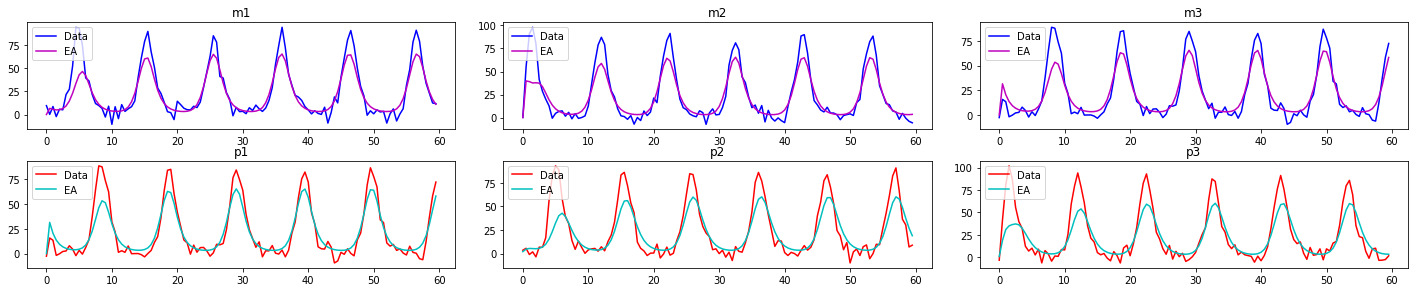

In [105]:
# PLEASE DO NOT REMOVE
# Generate signals for the best performing parameter values
repressilator.set_params(
    x[f.argmin()],
)
t, y_best = repressilator.solve_repressilator()

# Create plots
fig_ea, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_ea.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
            color_m = "m"
        else:
            title = "p"
            color = "r"
            color_m = "c"

        axs[i, j].plot(t, y_real[2 * i + j], color, label="Data")
        axs[i, j].plot(t, y_best[2 * i + j], color_m, label="EA")
        axs[i, j].set_title(title + str(j + 1))
        axs[i, j].legend()

Text(0.5, 1.0, '$n$ vs. $\\beta$')

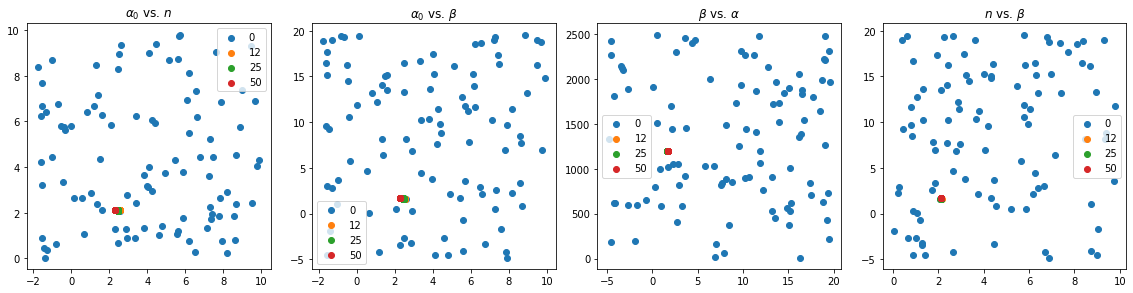

In [106]:
# PLEASE DO NOT REMOVE
# Generate scatterplots for the populations
gens = [0, num_generations // 4, num_generations // 2, num_generations]
fig_ea_pops, axs = plt.subplots(1, 4, figsize=(16, 4))
fig_ea_pops.tight_layout()


for i in range(len(gens)):
    pop_i = populations[gens[i]]
    axs[0].scatter(pop_i[:, 0], pop_i[:, 1], label=str(gens[i]))
    axs[1].scatter(pop_i[:, 0], pop_i[:, 2], label=str(gens[i]))
    axs[2].scatter(pop_i[:, 2], pop_i[:, 3], label=str(gens[i]))
    axs[3].scatter(pop_i[:, 1], pop_i[:, 2], label=str(gens[i]))
axs[0].legend(), axs[1].legend(), axs[2].legend(), axs[3].legend()
axs[0].set_title(r"$\alpha_0$ vs. $n$")
axs[1].set_title(r"$\alpha_0$ vs. $\beta$")
axs[2].set_title(r"$\beta$ vs. $\alpha$")
axs[3].set_title(r"$n$ vs. $\beta$")

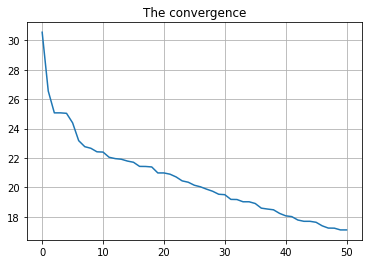

In [107]:
# PLEASE DO NOT REMOVE
# The convergence plot: the best value of the fitness function for each generation
plt.plot(range(len(f_best)), f_best)
plt.title("The convergence")
plt.grid()

## 4. Final remarks: Analysis

Eventually, please answer the following last questions that will allow you to conclude the assignment.

**Question 6 (0-0.5pt)**: After analyzing the results, do you think your algorithm discovered the real values of the parameters? Why? Please indicate which plots indicate that? If not, what is a potential explanation?

**Answer**: It often did not find the real values of the params as it seemed to get stuck at two local optima (converge too fast) at around 45 and 25. Howvwer, several runs and paramater adjusting made the values approach the real values, I think its not exact, as we can still see the difference between the graph shapes but compared to previous runs, it was on the right track. As we can see on the convergence graph, it is rather steady most of the run, meaning the algorithm found the real values and was approaching them over time instead of getting stuck. The 'slope' shape indicates convergence to the optimal solution, thus the convergence graph is the most telling in this case. The other two plots are however still important. I would have preferred to see a flat line at the end of the graph but wasn't able to finetune it enough in this case, but from my many runs I know this is getting to the correct point.

**Question 7 (0-0.5pt)**: How the population influences the performance of evolutionary algorithms? What population sizes did you use?

**Answer**: Usually larger populations lead to better results, and this was confirmed by my separate runs to find teh best possible fitness (which was around 13 for the 'perfect' run) and it choose the second highest popualtion size from the lsit (which is most likely coincidence, but confirms the bahaviour anyway on this scale). This is most liekly because of teh diversity inherent in larger populations but there is likely a point of diminishing returns as well. Considering our resources, we have to choose population sizes that will run in a reasonable time-frame. I tested increments of 25,50,75 and 100 for my testing as mentioned in Note 1. I dind't go higher to conserve resources, but it showed the behaviourr I expected nonetheless. Having kept the generations stable for all runs, there also could be a problem of larger populations not having time to converge within the run.

**Question 8 (0-0.5pt)**: What are the advantages of your approach?

**Answer**: My approach was to try everything to learn how different aspects of the code change the output and also was a good exercise to make a code to run the different combinations of the variables. So the advantage is that you can tune it as much as you like, which was very fun to implement but also crazy difficult to find the best solution. Considering the inherent randomness, it was more important in the end to udnerstand the patterns behind the changes rather than the perfect number itself. Again, this highlights what I was aiming for, to be able to learn as much as possible.

**Question 9 (0-0.5pt)**: What are the drawbacks of your approach?

**Answer**: It is hard to know sometimes if the changes I made made any difference. It is a black box in that way, especially when it comes to the code itself rather than the variable numbers themselves. It also takes a while to run as we are using all the functions so it adds up on time. Overall, the biggest drawback is the difficulty of finding the right combination of numbers to achieve the best results also due ot the randomness inside the evolutionary algorithm. With a bit more time and definetly more computational power, I am sure the perfect combination could be achieved, but in this approach with these circumstances it was not so easy.

**Question 10 (0-0.5pt)**: How could you improve convergence speed of your algorithm? Please provide very specific answer, ideally supported with literature and mathematical formulas.

**Answer**: Performing smaller calcualtions or less of them would help. I have noticed that a bigger tournament size leads or quicker run, which makes sense considering it is without replacement and it faster to compare 50 at once than 50 by 2s, as they require one less loop to execute, and there are libraies for efficient simultaneous comparison. Tournament is already understood as to be one of teh fastest in literature though. In general, an increased population size can also lead to quicker convergence due to more variety to pick and find solutions from. Howvwer, it is important to use crossover and mutation rates effectively to balance exploration and explotation. Finally, I have come across the idea of parallelism, where the runs run simultanously which not only improves computational time but can also increase convergence rate.

**Question 11 (0-0.5pt)**: How does an EA compares with the Metropolis-Hastings algorithm? What are the similarities? What are the differences?

**Answer**: Neither guarantess fiding the global minimum, both are stochastic and can be applied to non-linear and non-convex problems. They similarly require adjusting and readjusting to run well and efficiently as both are about the tradeoff between exploration and exploitation. The differences are that EAs do not use Markov Chain Monte Carlo, the method for Metropolis Hastings. EAs are as the name suggests use strategies baased on evolution or more specifically the mechanisms of natural selection. EAs start with a pool of eisting values upon which they itterate to approach the global minimum and solve the problem. MH using the chain to generate solutions 'in row' wgile EAs recombine and otherwise alter the entire pool. since they look at the whole population, they are more powerful for exploration compared to MH but are also more difficult to get right, to tune, as they use more methods and consider whole population, as opposed to MH which is mainly a balance of temperature and adjusting the porposal distribution.